In [ ]:
!nvidia-smi

Thu Feb  9 03:42:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchtext==0.8.0 torch==1.13.0 pytorch-lightning==1.2.2 --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.2/890.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.5/816.5 KB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 57.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.13.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==

In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)


Global seed set to 42
Global seed set to 42
INFO:lightning:Global seed set to 42


42

# Data

In [ ]:
!gdown --id 1c7t0jj4b1ORuQnL7hAFet8Vek-Oj00pw

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1c7t0jj4b1ORuQnL7hAFet8Vek-Oj00pw
To: /content/app_reviews.csv
100% 603k/603k [00:00<00:00, 119MB/s]


In [ ]:
df = pd.read_csv("app_reviews.csv")
df.head()

,id,review,class
0,1,"Besides the occasional crash, this is an amazi...",problem discovery
1,2,This could be a great app if it was predictabl...,problem discovery
2,3,I can't open since the last 2 updates Pop-ups ...,problem discovery
3,4,Use to love this app but it's not working afte...,problem discovery
4,5,"Urrrrm\tAfter my third re installing, it final...",problem discovery


In [ ]:
df[df['class'] == "user experience"]

,id,review,class
3084,3085,"Urrrrm\tAfter my third re installing, it final...",user experience
3085,3086,Does exactly what it says on the tin\tEffecien...,user experience
3086,3087,Best of what's available\tI've purchased a few...,user experience
3087,3088,Finally an Office Suite which works great\tI h...,user experience
3088,3089,Pretty good!\tI've edited many photos using th...,user experience
...,...,...,...
3686,3687,Loved this app from jump!\tHave never had any ...,user experience
3687,3688,Best app\tCan always edit my pics and they wil...,user experience
3688,3689,Awesome\tpics art is my only app for editing,user experience
3689,3690,5star!!!!!\tI love it! ! Sumtime hate it catch...,user experience


remove info giving class from dataset

In [ ]:
df = df[df['class'] != "information seeking"]

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.25)
train_df.shape, val_df.shape

((3735, 3), (1245, 3))

75 - 25 % split (training size - testing size)

# Preprocessing

## Distrubution of Labels

Let's look at the distribution of the labels:

[864, 2462, 444, 607, 603]


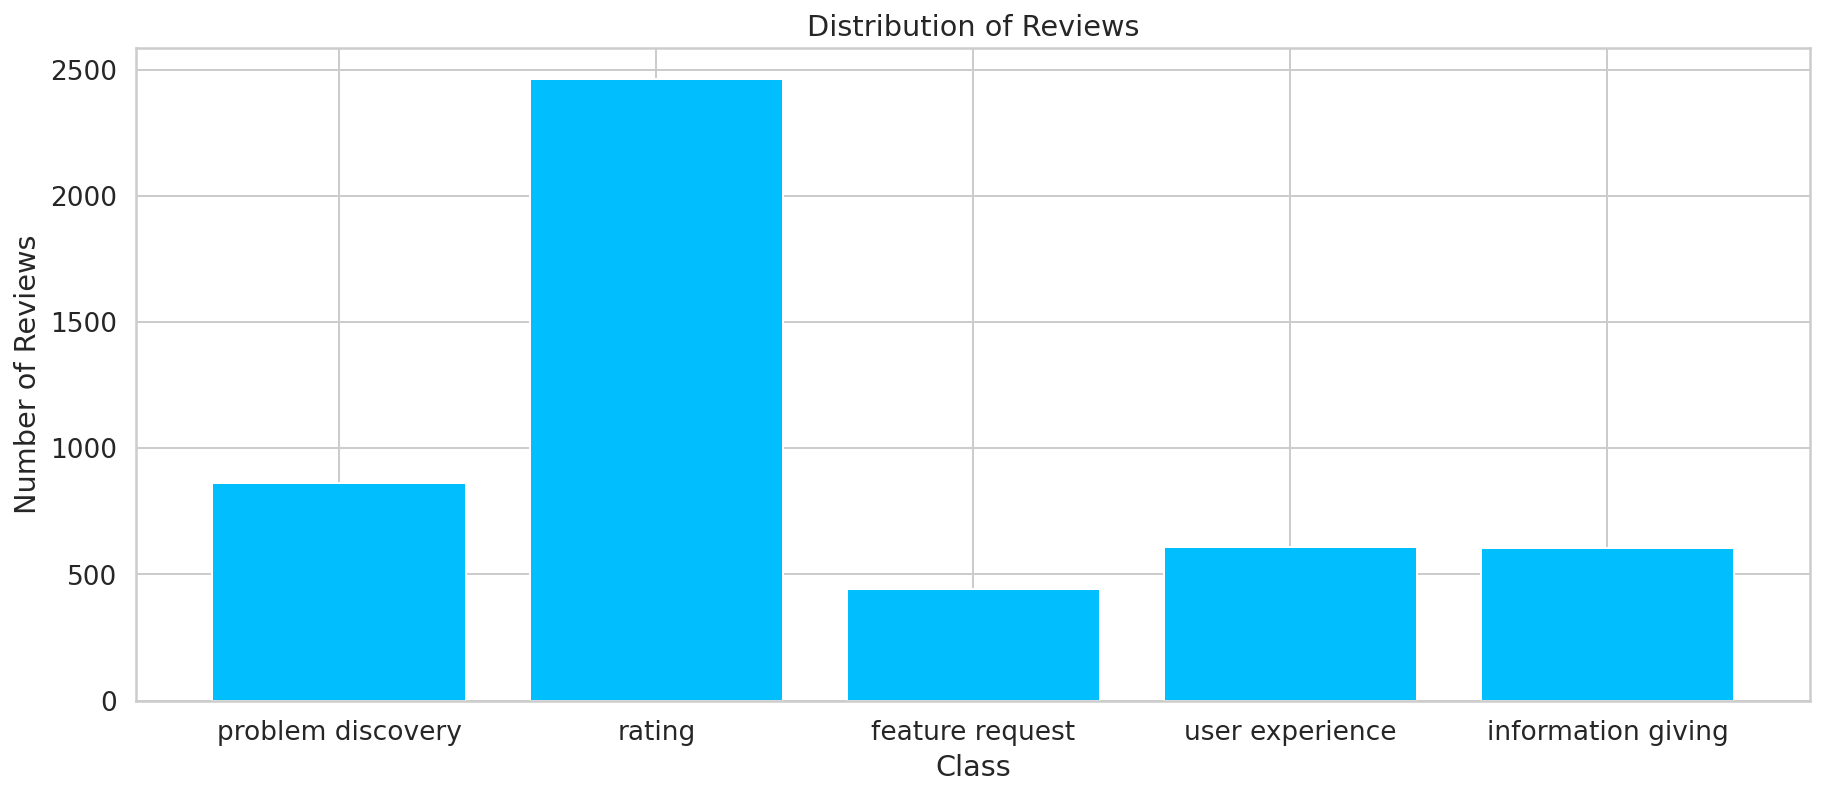

In [ ]:
CLASS_LABELS = df["class"].unique().tolist()
# CLASS_LABELS
fig = plt.figure(figsize=(15, 6))
y = [(df['class'] == label).sum() for label in CLASS_LABELS]
print(y)
# ax.bar(CLASS_LABELS, y)
plt.bar(CLASS_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews")
plt.show()

We have a server imbalance, we carry out undersamppling. To combat this, we'll sample *15,000* examples from the clean comments and create a new training set:

remove information seeking, take sample of all classes of len('feature request') (347 samples)

In [ ]:
pd_train = train_df[train_df['class']=="problem discovery"]
rating_train = train_df[train_df['class']=="rating"]
feature_train = train_df[train_df['class']=="feature request"]
user_experience_train = train_df[train_df['class']=="user experience"]
info_giving_train = train_df[train_df['class']=="information giving"]

no_samples = len(feature_train)

In [ ]:
train_df = pd.concat([
  pd_train.sample(no_samples),
  rating_train.sample(no_samples),
  feature_train,
  user_experience_train.sample(no_samples),
  info_giving_train.sample(no_samples)
])

train_df.shape, val_df.shape

((1710, 3), (1245, 3))

[342, 342, 342, 342, 342]


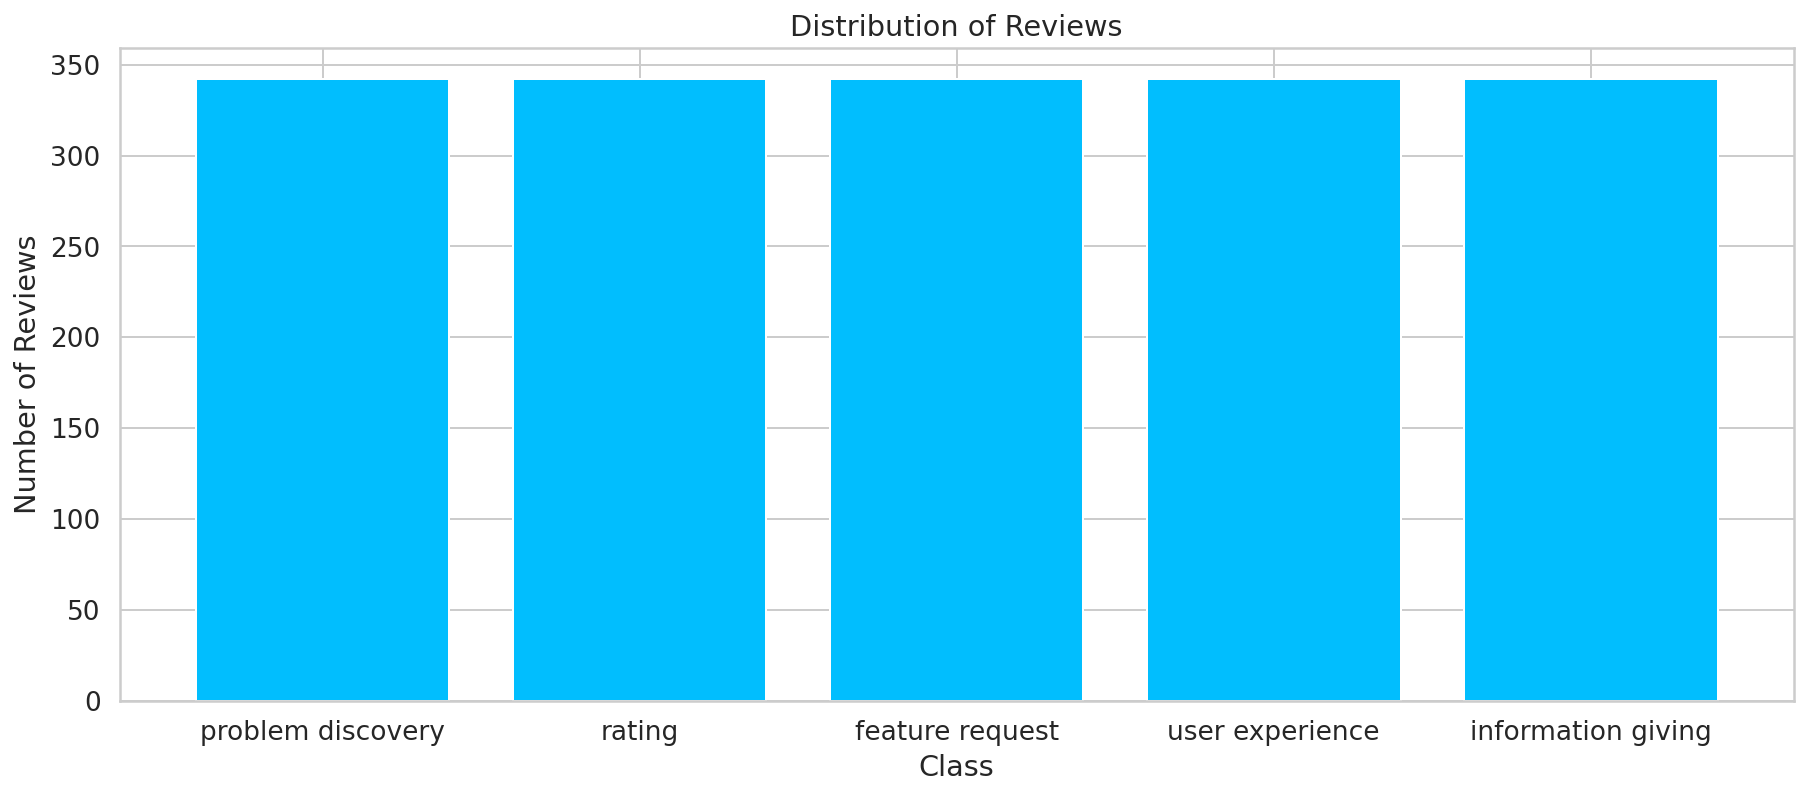

In [ ]:
CLASS_LABELS = df["class"].unique().tolist()
# CLASS_LABELS
fig = plt.figure(figsize=(15, 6))
y = [(train_df['class'] == label).sum() for label in CLASS_LABELS]
print(y)
# ax.bar(CLASS_LABELS, y)
plt.bar(CLASS_LABELS, y)
plt.xlabel("Class")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews")
plt.show()

Now we have an equal representation of samples from each set

## Tokenization
We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [ ]:
BERT_MODEL_NAME = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(BERT_MODEL_NAME)

Exmaple of tokenisation on app reviews:

In [ ]:
exmaple_review_row = df.iloc[36]
review = exmaple_review_row['review']
review_class = exmaple_review_row['class']

print(review)
print(review_class)

You need to improve the hebrew editing..
problem discovery


In [ ]:
encoding = tokenizer.encode_plus(
  review,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

The result of the encoding is a dictionary with token ids `input_ids` and an attention mask `attention_mask` (which tokens should be used by the model 1 - use or 0 - don't use).

Let's look at their contents:

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([    0,  1185,   240,     7,  1477,     5,    37, 30975,  5390,  7586,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1])

You can also inverse the tokenization and get back the words from the token ids:


In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['<s>', 'You', 'Ġneed', 'Ġto', 'Ġimprove', 'Ġthe', 'Ġhe', 'brew', 'Ġediting', '..', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per comment:

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["review"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

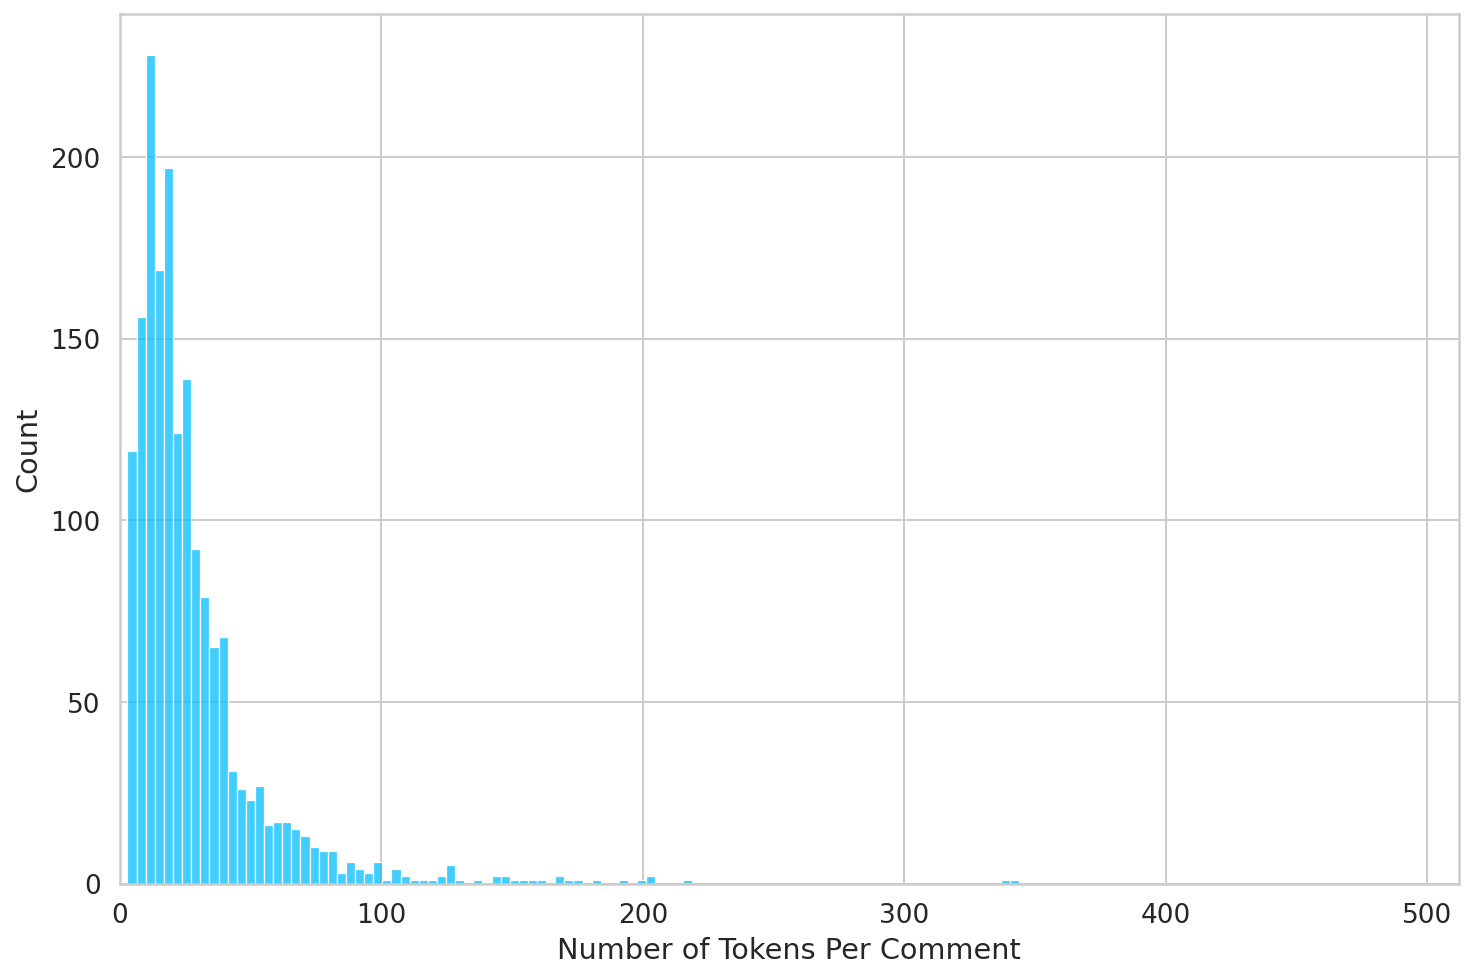

In [ ]:
sns.histplot(token_counts)
plt.xlabel("Number of Tokens Per Comment")
plt.xlim([0, 512]);

Most of the reviews contain less than 200 tokens and a maximum of ~400 Tokens. Therfore, setting the MAX TOKEN COUNT to 512 (default value) will be a waste of storage and processing resourceses.  

In [ ]:
MAX_TOKEN_COUNT = 400

## PyTorch Dataset 

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

Before we begin, a single class label need to be converted into a float vector.

In [ ]:
def label_vector(review_label):
  vector = {label:0 for label in CLASS_LABELS}
  vector[review_label]=1
  return list(vector.values())

In [ ]:
class AppReviewDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: BertTokenizer, max_token_len: int=128):
    self.data = data
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)
  
  ## return encoding of review
  def __getitem__ (self, index: int):
    data_row = self.data.iloc[index]
    review = data_row['review']
    label = data_row['class']
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=self.max_token_len,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    return dict(
        review=review,
        input_ids=encoding["input_ids"].flatten(),
        attention_mask=encoding["attention_mask"].flatten(),
        labels=torch.FloatTensor(label_vector(label))
    )    

Lets have a look at a sample review from t he dataset:

In [ ]:
train_dataset = AppReviewDataset(
    train_df,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

sample = train_dataset[470]
sample.keys()

dict_keys(['review', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample['review']

'Improving. Way to go.'

In [ ]:
sample['labels']

tensor([0., 1., 0., 0., 0.])

In [ ]:
sample['input_ids'].shape

torch.Size([400])

## Load BERT model and pass a sample of batch data through

In [ ]:
bert_model = RobertaModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 400]), torch.Size([8, 400]))

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 400, 768]), torch.Size([8, 768]))

The `768` dimension comes from the BERT hidden size:

In [ ]:
bert_model.config.hidden_size

768

The larger version of BERT has more attention heads and a larger hidden size.

The final step is to wrap our dataset into a lightningDataModule

In [ ]:
class AppReviewDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  # create dataset for each of the training and test sets
  def setup(self, stage=None):
    self.train_dataset = AppReviewDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )
    self.test_dataset = AppReviewDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2
    )
    
  # make predictions on a single example (single batch size)
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=2
    )
  
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=2
    )

AppReviewDataModule encapsulates all data loading logic and returns the necessary data loaders. Let’s create an instance of our data module:

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = AppReviewDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

# Model

The model will use a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task. This will all be backed in a LightningModule

In [ ]:
from torch.optim import lr_scheduler
class AppReviewTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    # classifier: serve as a way to get the output of the BERT model and convert those into the num of classes which we want to predict
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    # This criterion computes the cross entropy loss between input logits and target
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    # run linear layer ontop of the output
    output = self.classifier(output.pooler_output)
    # apply sigmoid function
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  
  def test_step(self, batch, batch_idx):
    input_ids = batch['input_ids']
    attention_mask = batch['attention_mask']
    labels = batch['labels']
    loss, outputs = self.forward(input_ids, attention_mask, labels)
    # output training loss
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    
    for output in outputs:
      for out_labels in output['labels'].detach().cpu():
        labels.append(out_labels)

      for out_predictions in output['predictions'].detach().cpu():
        predictions.append(out_predictions)

    # convert to tourch
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    # Calculate ROC score for each tag
    for i, name in enumerate(CLASS_LABELS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  # configer optimisers and learning rate scheduler
  def configure_optimizers(self):
    # fine tuning recomendations from original BERT paper
    optimizer = AdamW(self.parameters(), lr=2e-5)
  
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=self.n_warmup_steps,
        num_training_steps=self.n_training_steps
    )

    # return a list of optimisers and schedulers
    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
        )
    )

Most of the implementation is just a boilerplate. Two points of interest are the wat the optimizer is configured and calculating the area under ROC. We'll dive a bit deep into those next.

## Optimizer scheduler
The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We’ll use the get_linear_schedule_with_warmup.

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


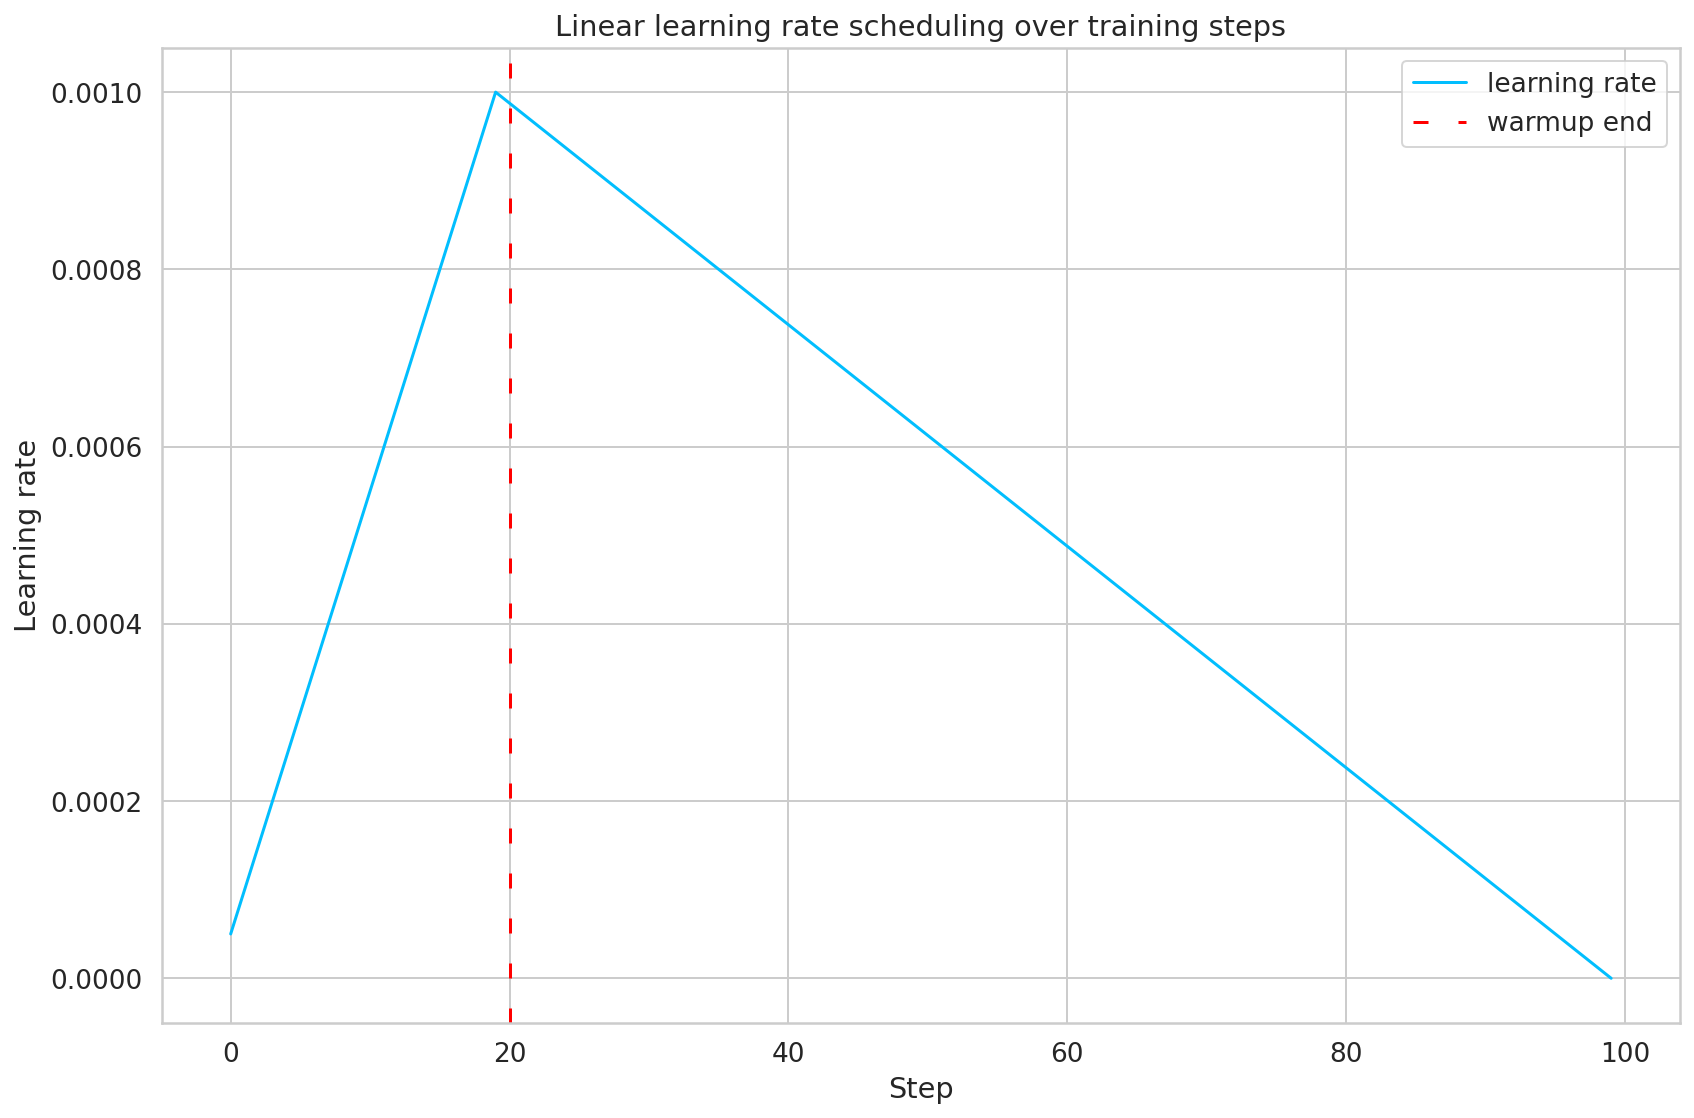

In [ ]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.title("Linear learning rate scheduling over training steps")
plt.tight_layout();

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to number of training examples / batch size. The number of total training steps is training steps per epoch * number of epochs:

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

We’ll use a fifth of the training steps for a warm-up:


In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(284, 1420)

We can now create an instance of our model:

In [ ]:
model = AppReviewTagger(
    n_classes=len(CLASS_LABELS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
    )

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at roberta-base were not used when initializing BertModel: ['roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.2.attention.self.value.weight', 'roberta.encoder.layer.4.output.dense.bias', 'roberta.encoder.layer.9.attention.self.query.weight', 'roberta.encoder.layer.11.attention.output.dense.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.output.dense.weight', 'roberta.encoder.layer.6.intermediate.dense.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.8.intermediate.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.output.dense.

# Evaluation

## Binary Cross Entropy Loss


Multi-label classification boils down to doing binary classification for each label/tag.

We’ll use Binary Cross Entropy to measure the error for each label. PyTorch has BCELoss, which we’re going to combine with a sigmoid function (as we did in the model implementation). Let’s look at an example:

In [ ]:
criterion = nn.BCELoss()
prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
)


In [ ]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

We can use the same approach to calculate the loss of the predictions:

In [ ]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions


tensor([[0.4025, 0.4955, 0.5076, 0.4978, 0.5932],
        [0.4214, 0.4925, 0.4986, 0.4876, 0.5989],
        [0.4241, 0.4571, 0.5123, 0.4999, 0.6068],
        [0.4163, 0.4766, 0.5003, 0.4903, 0.5944],
        [0.4105, 0.4878, 0.4883, 0.4910, 0.6102],
        [0.4098, 0.4821, 0.4920, 0.4964, 0.5945],
        [0.4282, 0.4958, 0.4969, 0.4880, 0.6157],
        [0.4333, 0.4990, 0.5032, 0.4875, 0.5998]], grad_fn=<SigmoidBackward0>)

In [ ]:
criterion(predictions, sample_batch["labels"])

tensor(0.7658, grad_fn=<BinaryCrossEntropyBackward0>)

## ROC Curve

Another metric we’re going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):

TPR= TP+FN / TP

​
FPR= FP+TN / FP


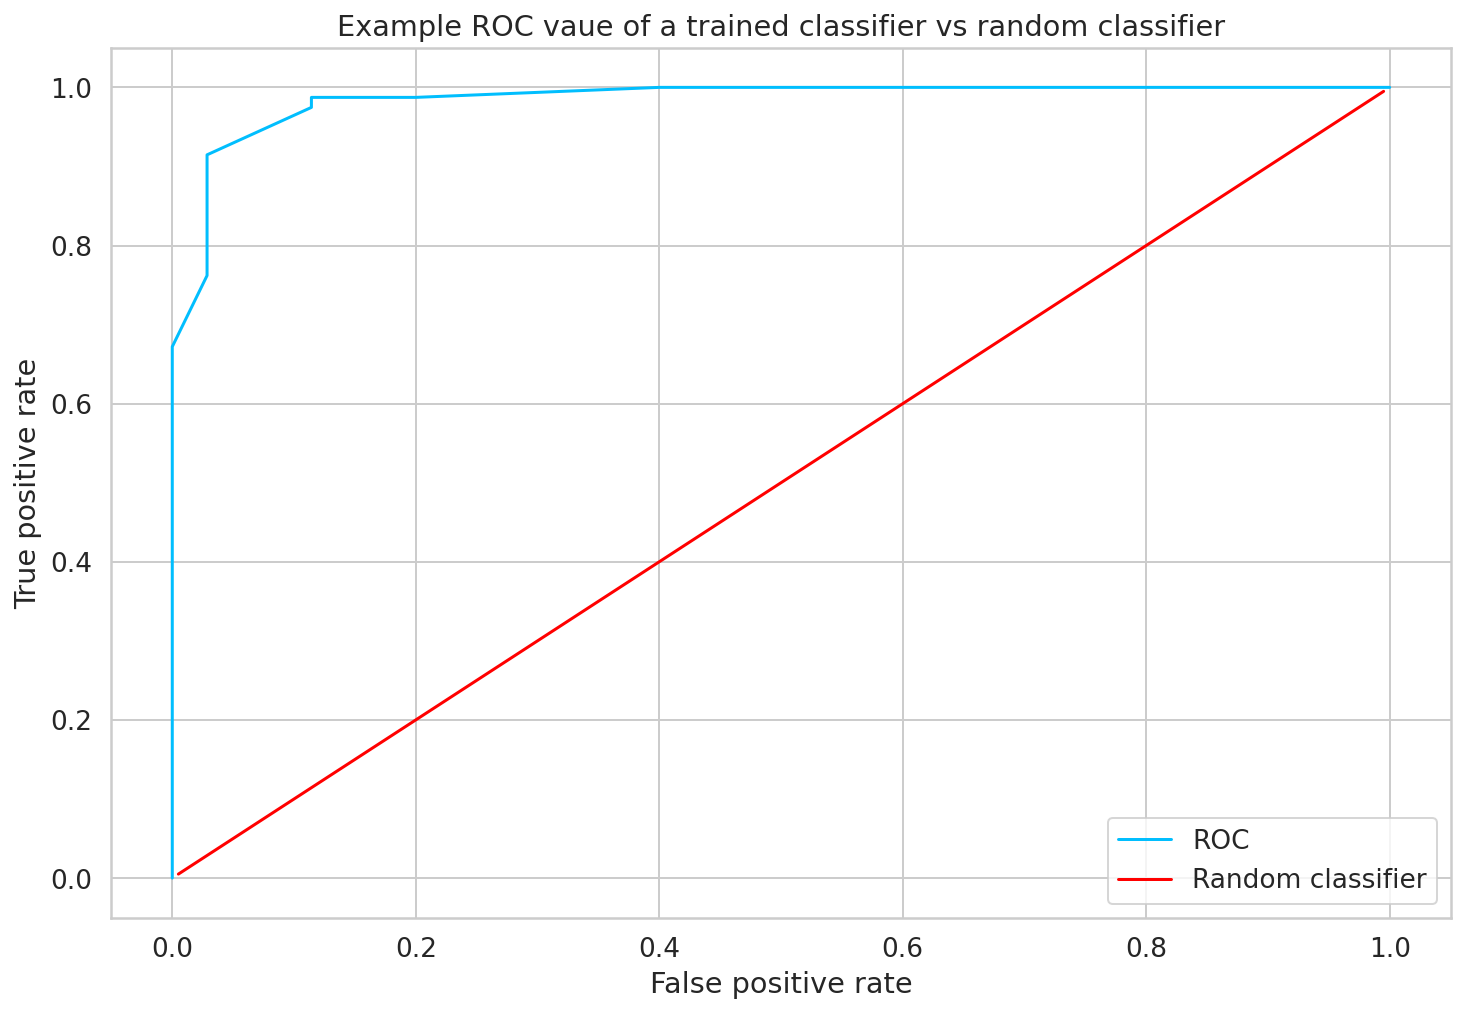

In [ ]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]
tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()

ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC vaue of a trained classifier vs random classifier")
plt.show();

# Training

The beauty of PyTorch Lightning is that you can build a standard pipeline that you like and train (almost?) every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):


In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

Log the progress in TensorBoard:



In [ ]:
logger = TensorBoardLogger("lightning_logs", name="app-comments")

And early stopping triggers when the loss hasn’t improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores


In [ ]:
trainer.fit(model, data_module)


  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 124 M 
1 | classifier | Linear    | 3.8 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.598   Total estimated model params size (MB)

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 124 M 
1 | classifier | Linear    | 3.8 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
498.598   Total estimated model params size (MB)
INFO:lightning:
  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 124 M 
1 | classifier | Linear    | 3.8 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
124 M     Trainable params
0         N

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


Validating: 0it [00:00, ?it/s]

Epoch 0, global step 142: val_loss reached 0.52556 (best 0.52556), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 0, global step 142: val_loss reached 0.52556 (best 0.52556), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
INFO:lightning:Epoch 0, global step 142: val_loss reached 0.52556 (best 0.52556), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 285: val_loss reached 0.45835 (best 0.45835), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 1, global step 285: val_loss reached 0.45835 (best 0.45835), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
INFO:lightning:Epoch 1, global step 285: val_loss reached 0.45835 (best 0.45835), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 428: val_loss reached 0.38327 (best 0.38327), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 2, global step 428: val_loss reached 0.38327 (best 0.38327), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
INFO:lightning:Epoch 2, global step 428: val_loss reached 0.38327 (best 0.38327), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 571: val_loss reached 0.37399 (best 0.37399), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 3, global step 571: val_loss reached 0.37399 (best 0.37399), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
INFO:lightning:Epoch 3, global step 571: val_loss reached 0.37399 (best 0.37399), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, global step 714: val_loss reached 0.37353 (best 0.37353), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 4, global step 714: val_loss reached 0.37353 (best 0.37353), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
INFO:lightning:Epoch 4, global step 714: val_loss reached 0.37353 (best 0.37353), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, global step 857: val_loss reached 0.34867 (best 0.34867), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 5, global step 857: val_loss reached 0.34867 (best 0.34867), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
INFO:lightning:Epoch 5, global step 857: val_loss reached 0.34867 (best 0.34867), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, step 1000: val_loss was not in top 1
Epoch 6, step 1000: val_loss was not in top 1
INFO:lightning:Epoch 6, step 1000: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 1143: val_loss reached 0.34376 (best 0.34376), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 7, global step 1143: val_loss reached 0.34376 (best 0.34376), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
INFO:lightning:Epoch 7, global step 1143: val_loss reached 0.34376 (best 0.34376), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 1286: val_loss reached 0.32132 (best 0.32132), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
Epoch 8, global step 1286: val_loss reached 0.32132 (best 0.32132), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1
INFO:lightning:Epoch 8, global step 1286: val_loss reached 0.32132 (best 0.32132), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, step 1429: val_loss was not in top 1
Epoch 9, step 1429: val_loss was not in top 1
INFO:lightning:Epoch 9, step 1429: val_loss was not in top 1


1

In [ ]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.32131627202033997}
--------------------------------------------------------------------------------


[{'test_loss': 0.32131627202033997}]

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./lightning_logs

#Evaluation

Let’s load the best version (according to the validation loss) of our model

In [ ]:
trained_model = AppReviewTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(CLASS_LABELS)
)
trained_model.eval()
trained_model.freeze()


You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at roberta-base were not used when initializing BertModel: ['roberta.encoder.layer.1.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.value.weight', 'roberta.encoder.layer.2.attention.self.value.weight', 'roberta.encoder.layer.4.output.dense.bias', 'roberta.encoder.layer.9.attention.self.query.weight', 'roberta.encoder.layer.11.attention.output.dense.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.attention.output.dense.weight', 'roberta.encoder.layer.6.intermediate.dense.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.8.intermediate.dense.weight', 'roberta.encoder.layer.11.output.LayerNorm.weight', 'roberta.encoder.layer.5.attention.output.dense.

We put our model into “eval” mode, and we’re ready to make some predictions. Here’s the prediction on a sample (totally fictional) comment:

Looks good. This one is pretty clean. We’ll reduce the noise of the predictions by thresholding (0.5) them. We’ll take only tag predictions above (or equal) to the threshold. Let’s try something toxic:


In [ ]:
test_review = "This app is great however there are issues when loading into the game, it is extermely slow. I believe this could be fixed by reducing the amount of textures loaded in at the beginning of the game."

THRESHOLD = 0.5

encoding = tokenizer.encode_plus(
    test_review,
    add_special_tokens=True,
    max_length=400,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
)


_, test_prediction = trained_model(encoding['input_ids'], encoding['attention_mask'])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(CLASS_LABELS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f'{label}: {prediction}')



problem discovery: 0.6208488941192627


Let’s get a more complete overview of the performance of our model. We’ll start by taking all predictions and labels from the validation set:



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = AppReviewDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
  
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()


  0%|          | 0/1245 [00:00<?, ?it/s]

One simple metric is the accuracy of the model:

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.8663)

This is good, but we have a very imbalanced dataset. Let’s check the ROC for each tag:



In [ ]:
print("AUROC per tag")
for i, name in enumerate(CLASS_LABELS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")


AUROC per tag
problem discovery: 0.8775628805160522
rating: 0.8996381759643555
feature request: 0.9092086553573608
user experience: 0.7905158400535583
information giving: 0.9226194620132446


let’s check the classification report for each class. To make this work, we must apply thresholding to the predictions:


In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true,
  y_pred,
  target_names=CLASS_LABELS,
  zero_division=0
))


                    precision    recall  f1-score   support

 problem discovery       0.71      0.66      0.68       227
            rating       0.88      0.67      0.76       606
   feature request       0.40      0.55      0.46       102
   user experience       0.35      0.37      0.36       156
information giving       0.66      0.71      0.68       154

         micro avg       0.68      0.63      0.65      1245
         macro avg       0.60      0.59      0.59      1245
      weighted avg       0.71      0.63      0.66      1245
       samples avg       0.62      0.63      0.62      1245



That gives us a much more realistic picture of the overall performance. The model makes mistakes on the tags will low amounts of examples.